In [149]:
# imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import datarobot as dr
import datarobot_ts_helpers as ts

# configs
pd.set_option('display.max_columns', None)

--------
# Step 1. Build a dataset

In [2]:
# assemble the dataset from various files
# because I am skipping the first exercises, I'll just do this in python instead of SQL
df_items = pd.read_csv('data/line_items.csv')
df_orders = pd.read_csv('data/orders.csv', parse_dates= ['ordered_at_utc'])
df_products = pd.read_csv('data/products.csv')

In [3]:
df_all = df_orders.merge(df_items, on= 'order_number', how= 'left')
df_all = df_all.merge(df_products, on= 'product_id', how= 'left')
df_all.drop_duplicates(inplace= True)
df_all.to_csv('data/raw_data_merged.csv', index= None)

In [4]:
df_all.head()

,order_number,ordered_at_utc,customer_uuid,discount,line_item_number,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost
0,148320207,2018-08-10 18:36:00,7407832334954,0.02,181686513.0,7.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16
1,148320207,2018-08-10 18:36:00,7407832334954,0.02,181686499.0,3.0,569775.0,T1850,Cotton Sweater,M,BLACK,21.87,8.04
2,148320207,2018-08-10 18:36:00,7407832334954,0.02,181687528.0,13.0,384233.0,T5000,Cotton T-shirt,XL,BLACK,5.43,1.95
3,158388486,2018-09-14 18:04:00,4792179702802,0.00,195761392.0,1.0,1609457.0,N1500,Ladies Tank,M,WHITE,4.81,1.97
4,319826542,2019-11-05 17:19:00,6361892924206,0.02,399938379.0,7.0,569768.0,T1850,Cotton Sweater,S,BLACK,21.79,8.03


In [5]:
df_all.shape

(266766, 13)

In [6]:
df_all['order_number'].nunique()

100090

In [7]:
df_all['product_id'].nunique()

70

## Engineer some simple features

In [8]:
# create a new daily-timestamp columns
df_all['date'] = pd.to_datetime(df_all['ordered_at_utc'].dt.date)

# create a few date-based features
df_all['hour_of_day'] = df_all['ordered_at_utc'].dt.hour
df_all['central_hod'] = df_all['ordered_at_utc'].dt.tz_localize('utc').dt.tz_convert('US/Central').dt.hour
df_all['Month'] = df_all['date'].dt.month
df_all['DOW'] = df_all['date'].dt.day_name()
df_all['Week'] = df_all['date'].dt.isocalendar().week

In [9]:
# create aggregate columns for row-based sales and cost
df_all['sales'] = df_all['units_sold'] * df_all['selling_price']
df_all['COGs'] = df_all['units_sold'] * df_all['supplier_cost']
df_all['revenue'] = df_all['sales'] - df_all['COGs']

In [68]:
# set column types
numerics = ['hour_of_day', 'central_hod', 'product_id','discount','units_sold', 'selling_price', 'supplier_cost', 'sales','COGs', 'revenue']
        
categoricals = ['order_number','customer_uuid', 'line_item_number',  'model_number', 'description', 'size', 'color']

for col in numerics:
    df_all[col] = df_all[col].astype(float)
    
for col in categoricals:
    df_all[col] = df_all[col].astype(str)

In [69]:
df_all.head(1)

,order_number,ordered_at_utc,customer_uuid,discount,line_item_number,units_sold,product_id,model_number,description,size,color,selling_price,supplier_cost,date,hour_of_day,central_hod,Month,DOW,Week,sales,COGs,revenue
0,148320207,2018-08-10 18:36:00,7407832334954,0.02,181686513.0,7.0,569789.0,T1850,Cotton Sweater,XL,BLACK,22.01,8.16,2018-08-10,18.0,13.0,8,Friday,32,154.07,57.12,96.95


-------
-------
# Exercise C: Data Insights
-------
-------

# Step 2. Brief Exploratory data analysis

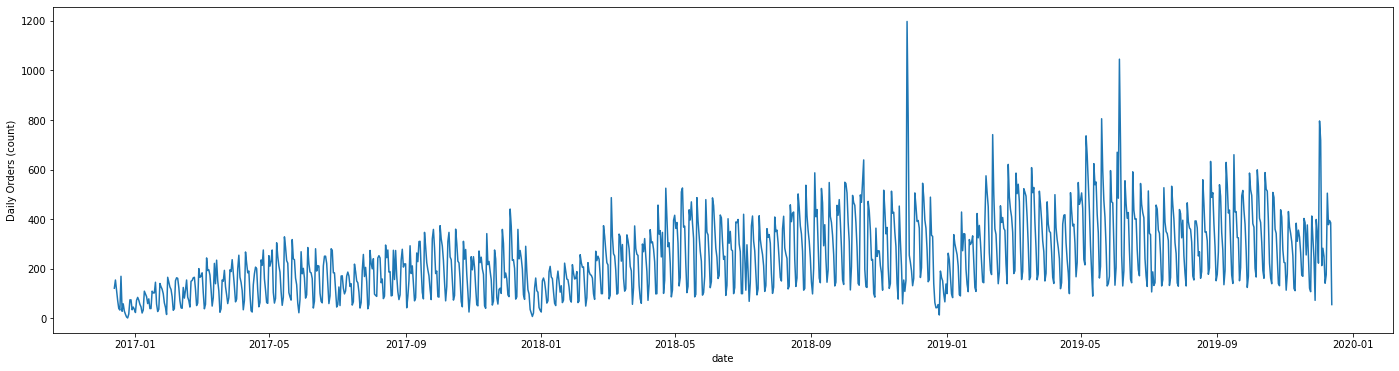

In [70]:
# what is the distribution of daily transactions over time?
tmp = df_all.groupby('date').count().reset_index()
plt.figure(figsize= (24,6))
sns.lineplot(x= 'date' ,y= 'order_number', data= tmp)
plt.ylabel('Daily Orders (count)')
plt.show();

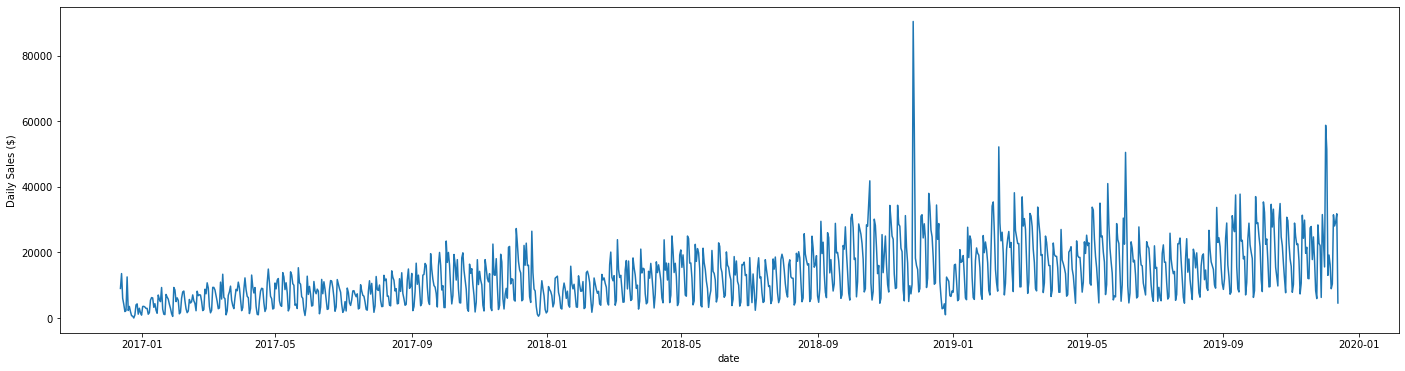

In [71]:
# Sales over time?
tmp = df_all.groupby('date').sum().reset_index()
plt.figure(figsize= (24,6))
sns.lineplot(x= 'date' ,y= 'sales', data= tmp)
plt.ylabel('Daily Sales ($)')
plt.show();

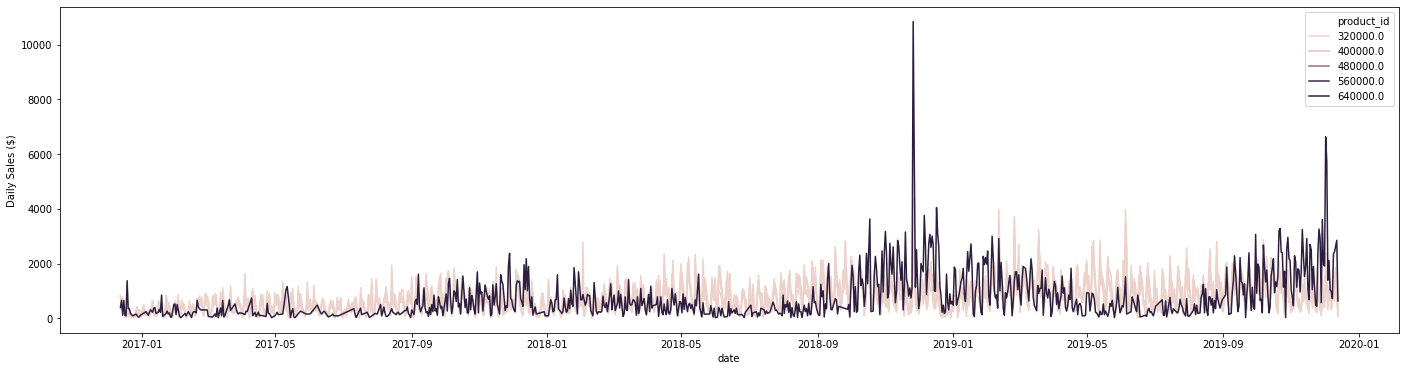

In [74]:
# Sales over time for 5-best sellers?
tmp = df_all.groupby(['date', 'product_id']).sum().reset_index()
top_5 = tmp.groupby('product_id').sum().reset_index().nlargest(5, 'sales')['product_id']
plt.figure(figsize= (24,6))
sns.lineplot(x= 'date' ,y= 'sales', data= tmp[tmp['product_id'].isin(top_5)], hue= 'product_id')
plt.ylabel('Daily Sales ($)')
plt.show();

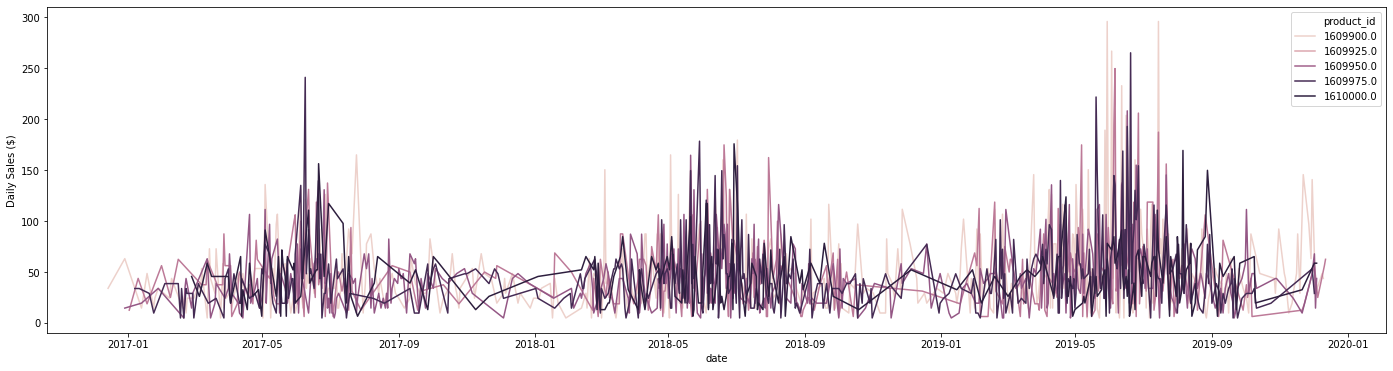

In [73]:
# Sales over time for 5-worst sellers?
tmp = df_all.groupby(['date', 'product_id']).sum().reset_index()
bottom_5 = tmp.groupby('product_id').sum().reset_index().nsmallest(5, 'sales')['product_id']
plt.figure(figsize= (24,6))
sns.lineplot(x= 'date' ,y= 'sales', data= tmp[tmp['product_id'].isin(bottom_5)], hue= 'product_id')
plt.ylabel('Daily Sales ($)')
plt.show();

#### Hello seasonal items and intermittent demand (zero-inflated series) ...

## Seasonality

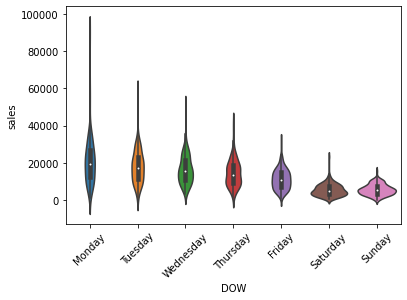

In [18]:
# what do daily sales look like across the week?
tmp = df_all.groupby(['date', 'DOW']).sum().reset_index()
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
sns.violinplot(x= 'DOW', y= 'sales', data= tmp, order= week_order)
plt.xticks(rotation= 45)
plt.show();

#### This is quite an interesting pattern. The lack of weekend sales suggests that 'retail' shoppers (i.e. individuals and not businesses) are not a huge portion of the sales, given how little weekend shopping we see.

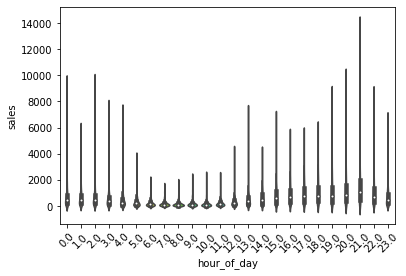

In [19]:
# Distribution of sales by hour of day (UTC)
tmp = df_all.groupby(['date', 'hour_of_day']).sum().reset_index()
# week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
sns.violinplot(x= 'hour_of_day', y= 'sales', data= tmp)
plt.xticks(rotation= 45)
plt.show();

#### Also interesting, the late-hours of sales peaks (and low weekend sales) suggest that perhaps most of the transactions do not occur in UTC time (GMT - UK). Rather, these likely occur in US time-zones.

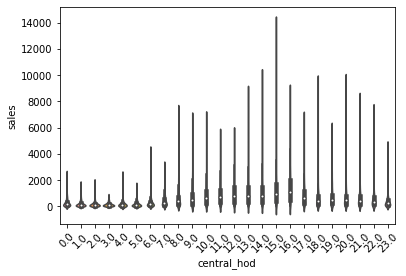

In [20]:
# Distribution of sales by hour (US-central)
tmp = df_all.groupby(['date', 'central_hod']).sum().reset_index()
# week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']
sns.violinplot(x= 'central_hod', y= 'sales', data= tmp)
plt.xticks(rotation= 45)
plt.show();

### That looks more reasonable with sales during 'normal' business hours, especially if we consider that some customers might be West of US-central.

#### To check that hypothesis, lets look at average time when customers purchase


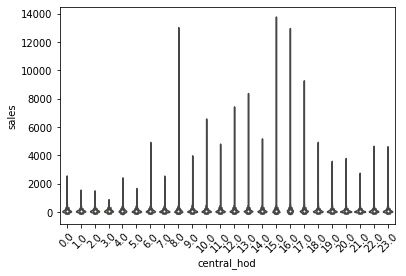

In [21]:
# look at the customer-based distribution for average sale-time
tmp = df_all.groupby(['customer_uuid', 'central_hod']).sum().reset_index()
sns.violinplot(x= 'central_hod', y= 'sales', data= tmp)
plt.xticks(rotation= 45)
plt.show();

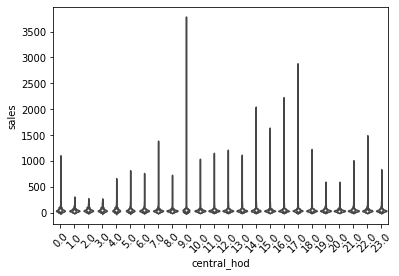

In [22]:
# look at the customer-based distribution for average sale-time
tmp = df_all.groupby(['customer_uuid', 'central_hod']).median().reset_index()
sns.violinplot(x= 'central_hod', y= 'sales', data= tmp)
plt.xticks(rotation= 45)
plt.show();

#### Sum vs median give slightly different insights, but both are more consistent with the idea that for most customers, purchases are happening during US-business hours (not evenings).

## Transactions

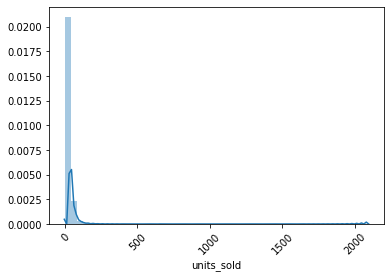

In [23]:
# lets look at average number of items purchased per transaction
tmp = df_all.groupby(['order_number']).sum().reset_index()
sns.distplot(tmp['units_sold'])
plt.xticks(rotation= 45)
plt.show();

#### Wow, there is a wide range, lets zoom in a bit

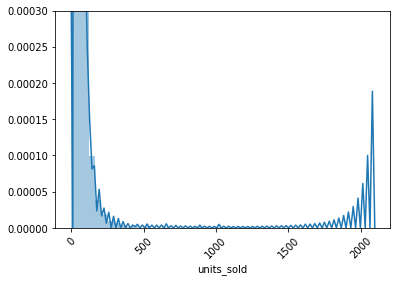

In [24]:
# lets look at average number of items purchased per transaction
tmp = df_all.groupby(['order_number']).sum().reset_index()
sns.distplot(tmp['units_sold'])
plt.ylim(0,0.0003)
plt.xticks(rotation= 45)
plt.show();

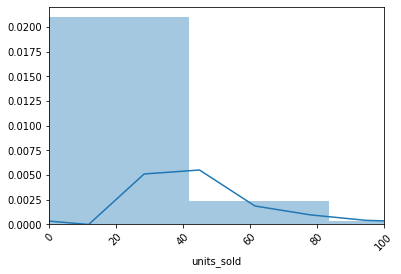

In [25]:
# zoom in more
tmp = df_all.groupby(['order_number']).sum().reset_index()
sns.distplot(tmp['units_sold'])
plt.xlim(0,100)
plt.xticks(rotation= 45)
plt.show();

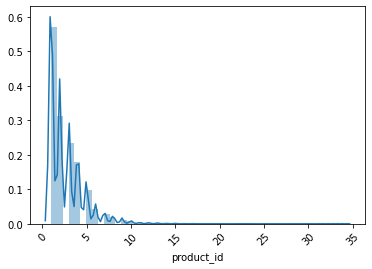

In [26]:
# lets look at average number of distinct items per transaction
tmp = df_all.groupby(['order_number']).count().reset_index()
sns.distplot(tmp['product_id'])
plt.xticks(rotation= 45)
plt.show();

## Customers

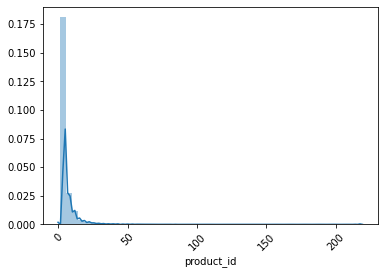

In [27]:
# how often do customers purchase from the store (all data)?
tmp = df_all.groupby(['customer_uuid']).count().reset_index()
sns.distplot(tmp['product_id'])
plt.xticks(rotation= 45)
plt.show();

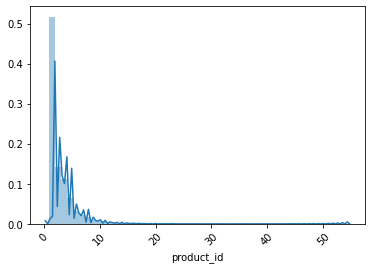

In [28]:
# how often do customers purchase from the store each month?
tmp = df_all.groupby(['customer_uuid', 'Month']).count().reset_index()
sns.distplot(tmp['product_id'])
plt.xticks(rotation= 45)
plt.show();

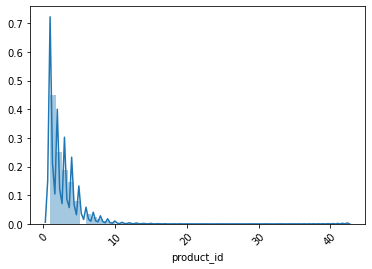

In [29]:
# how often do customers purchase from the store each week?
tmp = df_all.groupby(['customer_uuid', 'Week']).count().reset_index()
sns.distplot(tmp['product_id'])
plt.xticks(rotation= 45)
plt.show();

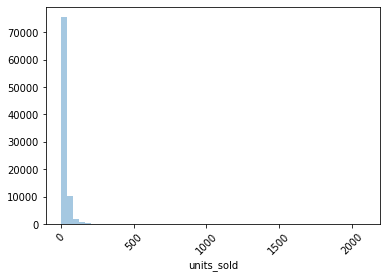

In [50]:
# What does the monthly sales look like across customers?
tmp = df_all.groupby(['customer_uuid', 'Month']).sum().reset_index()
sns.distplot(tmp['units_sold'], kde= False)
plt.xticks(rotation= 45)
plt.show();

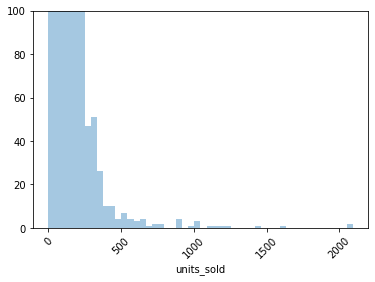

In [55]:
# What does the monthly sales look like across customers?
tmp = df_all.groupby(['customer_uuid', 'Month']).sum().reset_index()
sns.distplot(tmp['units_sold'], kde= False)
plt.ylim(0, 100)
plt.xticks(rotation= 45)
plt.show();

## Discounts

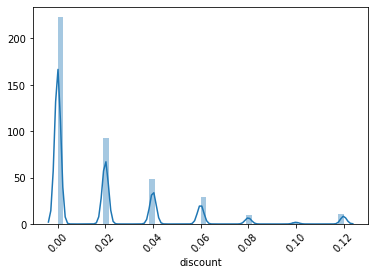

In [31]:
# how common are different discounts? 
sns.distplot(df_all['discount'])
plt.xticks(rotation= 45)
plt.show();

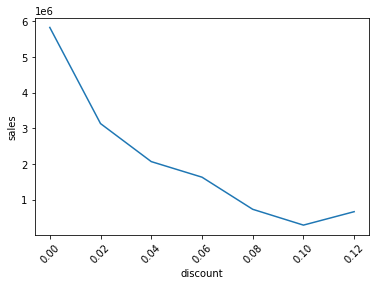

In [32]:
# how do discounts correlate with total sales?
tmp = df_all.groupby(['discount']).sum().reset_index()
sns.lineplot(x= 'discount', y= 'sales', data= tmp)
plt.xticks(rotation= 45)
plt.show();

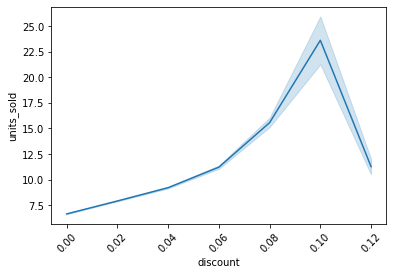

In [33]:
# how do discounts correlate with units_sold?
sns.lineplot(x= 'discount', y= 'units_sold', data= df_all)
plt.xticks(rotation= 45)
plt.show();

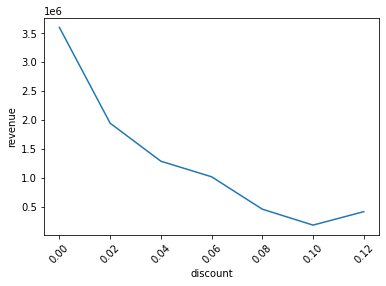

In [34]:
# how do discounts correlated with total revenue?
tmp = df_all.groupby(['discount']).sum().reset_index()
sns.lineplot(x= 'discount', y= 'revenue', data= tmp)
plt.xticks(rotation= 45)
plt.show();

## Row spacing (i.e. data regularity)

100%|██████████| 71/71 [00:00<00:00, 148.92it/s]


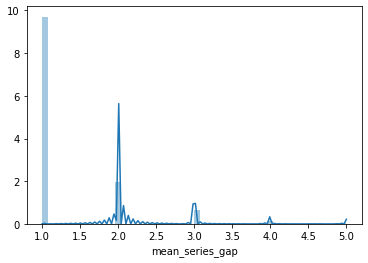

In [35]:
# how regular are sales for various items?
tmp = df_all.groupby(['date', 'product_id']).sum().reset_index()
mean_gap_dict = {}
max_gap_dict = {}
for series in tqdm(tmp['product_id'].unique()):
    mean_gap = tmp[tmp['product_id'] == series]['date'].diff().mean().days
    max_gap = tmp[tmp['product_id'] == series]['date'].diff().max().days
    mean_gap_dict[series] = mean_gap
    max_gap_dict[series] = max_gap
tmp['mean_series_gap'] = tmp['product_id'].map(mean_gap_dict)
tmp['max_series_gap'] = tmp['product_id'].map(max_gap_dict)


sns.distplot(tmp['mean_series_gap'])
plt.show();

In [208]:
tmp.groupby('product_id').mean()['mean_series_gap'].value_counts(dropna= False)

1    42
2    18
3     8
4     2
5     1
Name: mean_series_gap, dtype: int64

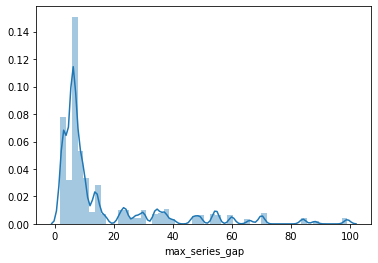

In [209]:
sns.distplot(tmp['max_series_gap'])
plt.show();

###$ Roughly 25% of the series are semi-regular (gaps greater than 1-day), and many have larger gaps

--------
# Conclusions and take-aways thus far:

### 1. Sales are driven mostly by 'commercial' customers (not a suprise)
- Sales occur during US-business hours
- Sales occur during the working-week, front loaded
- Customers purchase ~ 8 units of each item, and purchase ~ 2.5 different items per transaction on average (mean) (these are probably larger volumes than an individual would use)

### 2. Very strong weekly seasonality and annual seasonality
- Low-sales series show strong annual seasonality, indicative of seasonal items
- Constant selling items still show strong annual seasonality

### 3. Volatility and intermittent demand
- Across all items, there is high volatility.
- Intermittend demand is present across ~ 25% of the series
- Many series have larger gaps, so will be zero-inflated with many zero-target values

### 4. Product segmentation
- Given the different sales patterns across series, there are likely benefits associated wih segmentation of clustering approaches
- There are differences in single-item shoppers and multi-item shoppers, which could benefit from different treatment

### 5. Model-based insights
- In following section, we will see that model-based insights are also possible from the different approaches
- We see that the seasonality effects detected from EDA are critical for accurate modeling
- We also see that products can be segmented into different categories of seasonality (clustering work)
- From all of the modeling approaches, we see that Holidays have atypical impact: many holidays result in lower sales. This is consistent with the 'commercial customer' idea, as we might expect some of these businesses to be closed around US-holidays results in lower demand.

-------
---------
# Exercise B: Create Forecasts
------
-----

# Step 3. Build a daily-aggregate dataset
- This dataset needs to be aggregated to the daily level. Either multi-series or single-series
- That could be done really simply with a groupby statement for Auto-regressive models that don't use covariates 
- But, other approaches using covariates are highly effective, so instead I want to engineer features as I aggregate.
- To do that, I'll use some code I've written in the past for these types of operations

In [231]:
# prepare a univariate dataset
df_agg_univariate = df_all[['date', 'sales']].groupby('date').sum().reset_index()
df_agg_univariate.to_csv('data/single_series_univariate.csv', index= None)

In [232]:
# prepare a univariate, multi-series dataset
df_agg_multi_univariate = df_all[['date', 'sales', 'product_id']].groupby(['date', 'product_id']).sum().reset_index()
df_agg_multi_univariate.to_csv('data/multi_series_univariate.csv', index= None)

In [174]:
# prepare a simple, single-series dataset
df_agg_single = df_all[['date','sales', 'units_sold','COGs']].groupby('date').sum().reset_index()
df_agg_single['date'] = pd.to_datetime(df_agg_single['date'])
df_agg_single['mean_discount'] = df_all.groupby('date')['discount'].mean().reset_index()['discount']
df_agg_single['mean_selling_price'] = df_all.groupby('date')['selling_price'].mean().reset_index()['selling_price']
df_agg_single['mean_tranaction_sales'] = df_all.groupby('date')['sales'].mean().reset_index()['sales']
df_agg_single['mean_units_sold'] = df_all.groupby('date')['units_sold'].mean().reset_index()['units_sold']
df_agg_single['mean_COGs'] = df_all.groupby('date')['COGs'].mean().reset_index()['COGs']
# df_agg_single['series_id'] = 'single'
df_agg_single.to_csv('data/single_series_simple.csv', index= None)
df_agg_single.head(3)

,date,sales,units_sold,COGs,mean_discount,mean_selling_price,mean_tranaction_sales,mean_units_sold,mean_COGs
0,2016-12-13,9030.84,1153.0,3408.11,0.027213,9.506942,74.635041,9.528926,28.166198
1,2016-12-14,13563.65,1306.0,5080.87,0.024258,9.024570,89.825497,8.649007,33.648146
2,2016-12-15,6039.62,810.0,2258.00,0.020536,8.003551,56.445047,7.570093,21.102804


In [490]:
# prepare a simple, multi-series dataset
df_agg_multi = df_all[['date','sales', 'units_sold','COGs', 'revenue', 'product_id']].groupby(['date', 'product_id']).sum().reset_index()
df_agg_multi['date'] = pd.to_datetime(df_agg_multi['date'])
df_agg_multi['mean_tranaction_sales'] = df_all.groupby(['date', 'product_id'])['sales'].mean().reset_index()['sales']
df_agg_multi['mean_discount'] = df_all.groupby(['date', 'product_id'])['discount'].mean().reset_index()['discount']
df_agg_multi['mean_selling_price'] = df_all.groupby(['date', 'product_id'])['selling_price'].mean().reset_index()['selling_price']
df_agg_multi['mean_units_sold'] = df_all.groupby(['date', 'product_id'])['units_sold'].mean().reset_index()['units_sold']
df_agg_multi['mean_COGs'] = df_all.groupby(['date', 'product_id'])['COGs'].mean().reset_index()['COGs']
df_agg_multi.to_csv('data/multi_series_simple.csv', index= None)
df_agg_multi.head(3)

# however, additional information is know that can be included
known_info = ['description', 'color', 'size', 'model_number']
for col in known_info:
    df_agg_multi[col] = df_agg_multi['product_id'].map(dict(zip(df_all.groupby('product_id')[col].first().index, df_all.groupby('product_id')[col].first().values)))

# df_agg_multi = df_agg_multi[df_agg_multi['date'].notna()].copy()
print('Row count: ', df_agg_multi.shape[0])
df_agg_multi.head(3)

Row count:  49291


,date,product_id,sales,units_sold,COGs,revenue,mean_tranaction_sales,mean_discount,mean_selling_price,mean_units_sold,mean_COGs,description,color,size,model_number
0,2016-12-13,383372.0,132.0,33.0,54.12,77.88,44.000000,0.046667,4.00,11.000000,18.040000,Cotton T-shirt,WHITE,S,T5000
1,2016-12-13,383379.0,102.7,26.0,39.52,63.18,34.233333,0.040000,3.95,8.666667,13.173333,Cotton T-shirt,WHITE,M,T5000
2,2016-12-13,383386.0,243.1,65.0,100.75,142.35,243.100000,0.060000,3.74,65.000000,100.750000,Cotton T-shirt,WHITE,L,T5000


---------
# Building Forecasts, Approach 1: 'Simple' DataRobot solution - Single series

 I'll quickly highlight building a simple single-series and multi-series approach for forecasting this in DataRobot.

 Because DataRobot automates a lot of the 'routine' data science tasks with guardrails, I don't need to worry too much about feature engineering, data partitioning, making the dataset stationary, etc.

 All of that will automatically be handled for me, and I'll get the most accurate results given my dataset with dozens of approaches tested.

 First, I'll show this process with direct python-client calls

In [439]:
# configure connection to DataRobot
# endpoint and API-token are stored in a config file

# US-server
dr.Client(config_path='/Users/jarred.bultema/.config/datarobot/drconfig.yaml', connect_timeout= 50000)

### DataRobot uses a forecasting approach known as 'Forecast Distance modeling' for many of it's approaches. In essense, it will build a separate forecast for each point within a forecast horizon. In this case, we want to forecast to the end of 2019:

In [171]:
pd.to_datetime('2019-12-31') - df_agg_single['date'].max()

Timedelta('18 days 00:00:00')

In [206]:
# DataRobot will automatically handle partitioning, but let's specifically define this so we can compare across approaches
# lets use 2x 30-day validation periods (1x holdout and 1x validation)
print('30 days back: ', (df_agg_single['date'].max() + pd.DateOffset(-30)).date())
print('60 days back: ', (df_agg_single['date'].max() + pd.DateOffset(-60)).date())

30 days back:  2019-11-13
60 days back:  2019-10-14


In [207]:
# DataRobot also has the ability to use calendar files with holiday events.
# these can be autogenerated, but I have a simple example:
US_cal = pd.read_csv('data/US_holiday_calendar.csv')

US_cal.head(5)

,date,event_type
0,12/25/16,Christmas Day
1,12/26/16,Christmas Day (Observed)
2,1/1/17,New Year's Day
3,1/2/17,New Year's Day (Observed)
4,1/16/17,"Martin Luther King, Jr. Day"


In [208]:
cal = dr.CalendarFile.create(file_path='data/US_holiday_calendar.csv', calendar_name='US_holiday_cal', multiseries_id_columns=None)
print(cal.id)

605f58e53ea8a61a44b2800b


In [391]:
%%time
project_1 = dr.Project.create(df_agg_single, project_name= 'JS: single-series project with cal')
    
specs = dr.DatetimePartitioningSpecification(
    datetime_partition_column='date',
    autopilot_data_selection_method= 'duration',
    validation_duration=dr.helpers.partitioning_methods.construct_duration_string(days=30),
    holdout_start_date=pd.to_datetime('2019-11-13'),
    holdout_duration=dr.helpers.partitioning_methods.construct_duration_string(days= 30),
    disable_holdout=False,
    gap_duration=dr.helpers.partitioning_methods.construct_duration_string(days=0),
    number_of_backtests=1,
    use_time_series=True,
    feature_derivation_window_start=-35,
    feature_derivation_window_end=0,
    forecast_window_start=1,
    forecast_window_end=30,
    multiseries_id_columns=None,
    use_cross_series_features=False,
    calendar_id=cal.id,
)
    
project_1 = project_1.set_target('sales', 
                             mode='auto',
                            partitioning_method=specs,
                            worker_count=-1,
                            metric='RMSE',
                            )
ts.wait_for_jobs_to_process([project_1])

There are 24 jobs still processing
There are 22 jobs still processing
There are 13 jobs still processing
There are 5 jobs still processing
There are 2 jobs still processing
There are 1 jobs still processing
There are 5 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
All jobs have finished processing...
CPU times: user 447 ms, sys: 99 ms, total: 546 ms
Wall time: 16min 47s


In [392]:
# see all of the approaches that DataRobot used
DR_models = project_1.get_models()
DR_models

[Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('AVG Blender'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Keras DeepAR LSTM Regressor with Poisson Probabilistic Distribution Modeling using Training Schedule (1 LSTM Layer: 40 Units)'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Eureqa Generalized Additive Model (250 Generations) (Poisson Loss)'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (mixing alpha=0.5 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Baseline Predictions Using Most Recent Value (periodicity=7 days)'),
 Model('Elastic-Net Regressor (L2 / Poisson Devi

In [394]:
# get the most accurate model based on validation data (holdout is locked away until we choose to unlock it. No cheating!)
data_subset= 'validation'
sorted_models_RMSE = sorted(DR_models, key=lambda m:  m.metrics['RMSE'][data_subset] if m.metrics['RMSE'][data_subset] is not None else np.nan, reverse=False)
sorted_models_MAPE = sorted(DR_models, key=lambda m:  m.metrics['MAPE'][data_subset] if m.metrics['MAPE'][data_subset] is not None else np.nan, reverse=False)
sorted_models_RMSE

[Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('AVG Blender'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Keras DeepAR LSTM Regressor with Poisson Probabilistic Distribution Modeling using Training Schedule (1 LSTM Layer: 40 Units)'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Eureqa Generalized Additive Model (250 Generations) (Poisson Loss)'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (mixing alpha=0.5 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling'),
 Model('Baseline Predictions Using Most Recent Value (periodicity=7 days)'),
 Model('Elastic-Net Regressor (L2 / Poisson Devi

In [395]:
best_model = sorted_models_RMSE[0] # more accurate model by RMSE
DR_model = sorted_models_MAPE[1] # this proprietary, evolutionary model is quite interesting
print('Best DR model: ', best_model)
print('Interesting DR model: ', DR_model)

Best DR model:  Model('Elastic-Net Regressor (L2 / Poisson Deviance) with Forecast Distance Modeling')
Interesting DR model:  Model('Eureqa Generalized Additive Model (250 Generations) (Poisson Loss)')


In [396]:
# get a prediction for the holdout data from DataRobot
# (we can retrieve this directly from the DataRobot model object if we unlock and calculate the holdout score with an API call, but showing the upload path here)
training_pred_dataset = project_1.upload_dataset(df_agg_single, forecast_point= pd.to_datetime('2019-11-12'))
forecast_request = best_model.request_predictions(training_pred_dataset.id)
DR_forecast = forecast_request.get_result_when_complete()
DR_forecast.head(3)

,forecast_distance,forecast_point,prediction,original_format_timestamp,row_id,timestamp
0,1,2019-11-12T00:00:00.000000Z,26389.804109,2019-11-13,1064,2019-11-13T00:00:00.000000Z
1,2,2019-11-12T00:00:00.000000Z,23610.077647,2019-11-14,1065,2019-11-14T00:00:00.000000Z
2,3,2019-11-12T00:00:00.000000Z,17260.487533,2019-11-15,1066,2019-11-15T00:00:00.000000Z


In [397]:
# get a prediction for the holdout data from DataRobot
# (we can retrieve this directly from the DataRobot model object if we unlock and calculate the holdout score with an API call, but showing the upload path here)
forecast_request2 = DR_model.request_predictions(training_pred_dataset.id)
DR_forecast2 = forecast_request2.get_result_when_complete()
DR_forecast2.head(3)

,forecast_distance,forecast_point,prediction,original_format_timestamp,row_id,timestamp
0,1,2019-11-12T00:00:00.000000Z,22993.486101,2019-11-13,1064,2019-11-13T00:00:00.000000Z
1,2,2019-11-12T00:00:00.000000Z,20616.389859,2019-11-14,1065,2019-11-14T00:00:00.000000Z
2,3,2019-11-12T00:00:00.000000Z,16075.139787,2019-11-15,1066,2019-11-15T00:00:00.000000Z


#### you'll notice that DataRobot generates a 'forecast distance', which means that only actual observed data was used to generate the predictions (not rolling forward on previoulsy predicted values like most forecasting approaches)

In [398]:
DR_forecast['timestamp'] = pd.to_datetime(DR_forecast['timestamp']).dt.tz_localize(tz= None)
DR_forecast2['timestamp'] = pd.to_datetime(DR_forecast2['timestamp']).dt.tz_localize(tz= None)

# rename predictions to avoid confusion
DR_forecast.rename(columns= {'prediction': 'DR ENET Prediction'}, inplace= True)
DR_forecast2.rename(columns= {'prediction': 'DR Eureqa Prediction'}, inplace= True)

### We can examine the features used by the most accurate DataRobot model and see the relative importance. This also highlights the degree of automated feature engineering that has occurred and been used by the models.

Text(0.5, 1.04, 'Feature Impact')

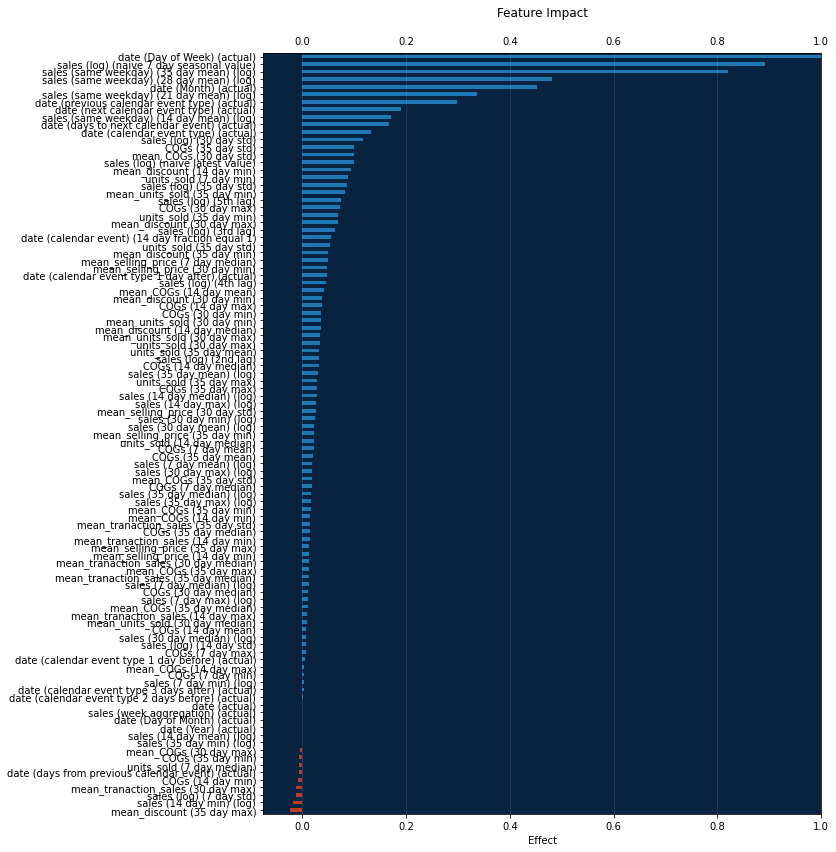

In [399]:
# a major advantage of the DataRobot models is that all will have interpretability built-in
# here we retrieve the 'Feature Impact' (i.e. Permutation importance)
feature_impacts = best_model.get_or_request_feature_impact()

# percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'
impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 14))
# ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

In [400]:
# we can also see the 'Prediction Explanations for each prediction' (i.e. 'Why did the model make this prediction for this row?')
pei_job = dr.PredictionExplanationsInitialization.create(project_1.id, best_model.id)
pei_job.wait_for_completion()
pe_job = dr.PredictionExplanations.create(project_1.id, best_model.id, training_pred_dataset.id, max_explanations=5)
pe = pe_job.get_result_when_complete()
pe = pe.get_all_as_dataframe()

In [401]:
pe.head()

,row_id,prediction,explanation_0_feature,explanation_0_feature_value,explanation_0_label,explanation_0_qualitative_strength,explanation_0_strength,explanation_1_feature,explanation_1_feature_value,explanation_1_label,explanation_1_qualitative_strength,explanation_1_strength,explanation_2_feature,explanation_2_feature_value,explanation_2_label,explanation_2_qualitative_strength,explanation_2_strength,explanation_3_feature,explanation_3_feature_value,explanation_3_label,explanation_3_qualitative_strength,explanation_3_strength,explanation_4_feature,explanation_4_feature_value,explanation_4_label,explanation_4_qualitative_strength,explanation_4_strength
0,1064,26389.804109,date (calendar event) (14 day fraction equal 1),0.0714286,sales (actual),++,1581.082770,sales (same weekday) (35 day mean) (log),10.1304,sales (actual),++,1171.417618,date (next calendar event type) (actual),Thanksgiving,sales (actual),--,-1158.202131,sales (same weekday) (28 day mean) (log),10.1559,sales (actual),++,1090.786393,sales (log) (4th lag),8.9024,sales (actual),++,1010.070614
1,1065,23610.077647,date (calendar event) (14 day fraction equal 1),0.0714286,sales (actual),++,1042.882057,mean_units_sold (35 day min),6.31624,sales (actual),--,-806.879512,sales (log) (naive 7 day seasonal value),10.0249,sales (actual),++,771.950856,sales (log) (4th lag),8.9024,sales (actual),++,700.683972,date (next calendar event type) (actual),Thanksgiving,sales (actual),--,-689.979116
2,1066,17260.487533,sales (log) (4th lag),8.9024,sales (actual),---,-1009.266901,date (calendar event) (14 day fraction equal 1),0.0714286,sales (actual),++,676.263322,mean_units_sold (35 day min),6.31624,sales (actual),--,-566.578357,sales (log) (naive 7 day seasonal value),9.76704,sales (actual),--,-538.208335,date (next calendar event type) (actual),Thanksgiving,sales (actual),--,-522.892975
3,1067,9829.363022,sales (log) (naive 7 day seasonal value),8.9024,sales (actual),---,-2730.907815,sales (same weekday) (14 day mean) (log),8.93628,sales (actual),--,-865.321560,sales (same weekday) (21 day mean) (log),9.10922,sales (actual),--,-796.879220,sales (same weekday) (35 day mean) (log),9.19681,sales (actual),--,-793.533200,sales (same weekday) (28 day mean) (log),9.20617,sales (actual),--,-731.311616
4,1068,12174.933492,sales (log) (naive 7 day seasonal value),9.27307,sales (actual),---,-2064.476771,sales (same weekday) (35 day mean) (log),9.16997,sales (actual),--,-903.496466,sales (same weekday) (28 day mean) (log),9.16974,sales (actual),--,-877.285826,sales (same weekday) (21 day mean) (log),9.1633,sales (actual),--,-824.236101,date (Day of Week) (actual),6,sales (actual),--,-717.854514


#### We can observe the frequency at which date-based features (Month, Day of Week, calendar events) are most or next-most important for determining the prediction. The other top-features driving predictions are mainly related to lagged values of sales, typically also incorporating seasonal effects. This is demonstration of just how significant these different seasonal periods are for sales of JiffySwift products.

In [646]:
pe['explanation_0_feature'].value_counts()

date (Day of Week) (actual)                        7
sales (log) (naive 7 day seasonal value)           5
date (calendar event) (14 day fraction equal 1)    4
date (previous calendar event type) (actual)       4
date (Month) (actual)                              3
sales (same weekday) (35 day mean) (log)           3
date (calendar event type) (actual)                2
date (calendar event type 1 day after) (actual)    1
sales (log) (4th lag)                              1
Name: explanation_0_feature, dtype: int64

In [648]:
pe['explanation_1_feature'].value_counts()

date (Month) (actual)                              6
sales (same weekday) (35 day mean) (log)           6
date (previous calendar event type) (actual)       4
date (Day of Week) (actual)                        3
sales (log) (naive 7 day seasonal value)           3
mean_units_sold (35 day min)                       2
date (days to next calendar event) (actual)        2
date (calendar event type 1 day after) (actual)    1
sales (same weekday) (28 day mean) (log)           1
date (calendar event) (14 day fraction equal 1)    1
sales (same weekday) (14 day mean) (log)           1
Name: explanation_1_feature, dtype: int64

-----
# Build Forecasts, Approach 2: FB Prophet

The Prophet package, created by the core modeling team at Facebook, provides a simple approach to do forecasting with univariate data. 

It does not include any information about covariates (discount, item info, etc). Rather, it uses either an additive or multiplicative Generalized Linear Model (GLM) framework that uses a decomposition approach into Trend, Seasonal, and Error components (similar to ARIMA).

It provides a simple, fast framework to quickly build models, and does provide some opportunity for performance improvement. As an example, Prophet can also use holiday calendars to improve forecasting performance, as included here.

The downside is that Prophet is uses univariate data and doesn't scale to multi-series problems.

In [405]:
from prophet import Prophet

In [406]:
# prophet requires specific column naming for training files and calendars
df_prophet = df_agg_univariate.copy()
df_prophet.rename(columns= {'date': 'ds', 'sales': 'y'}, inplace= True)

prophet_cal = US_cal.copy()
prophet_cal.rename(columns= {'date': 'ds', 'event_type': 'holiday'}, inplace= True)

# we also need to exclude the holdout data from the prophet training file for fair comparison (the DataRobot models haven't been trained with that data yet)
prophet_train = df_prophet[df_prophet['ds'] < pd.to_datetime('2019-10-14')]

In [407]:
# I'll use some knowledge from the EDA process and calendar file to boost performance
prophet_model = Prophet(holidays= prophet_cal, weekly_seasonality= True)
prophet_model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [408]:
# create the scoring dataset for prophet (the holdout period to start)
prophet_forecast = prophet_model.predict(df_prophet)
prophet_forecast['ds'] = pd.to_datetime(prophet_forecast['ds'])

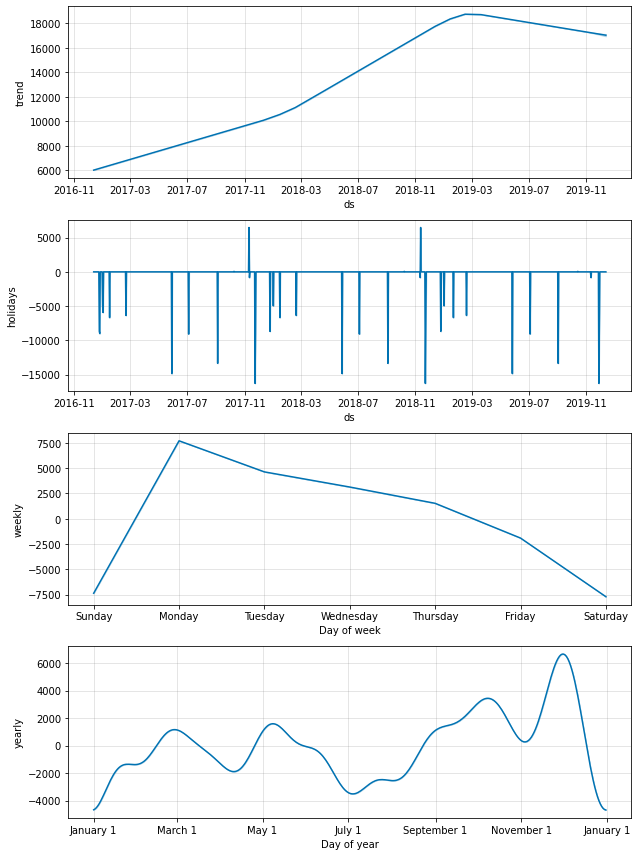

In [645]:
# Prophet is nice because you can see the decomposition components
# this is interesting, but not really actionable in many ways (can use it to tune Prophet performance)
fig_components= prophet_model.plot_components(prophet_forecast)

As we'd seen from the EDA and from the Features used by the DataRobot model (above), the weekly and annual seasonality effects are extremely prominent in the Prophet model. Interestingly, the Prophet model provides insight that most US-bank holidays actually result in reduced sales, with only a few specific holidays corresponding to enhanced sales. This is again consistent with the 'commercial buyer' hypothesis as one would imagine that those businesses might be closed for some holiday and have less short-term demand.

## Compare the performance of Prophet and DataRobot on out-of-sample data (i.e. holdout data not seen by models)


In [409]:
training_results = df_agg_single.merge(DR_forecast, left_on = 'date', right_on = 'timestamp', how= 'inner')\
                        .merge(DR_forecast2, left_on = 'date', right_on = 'timestamp', how= 'inner')\
                        .merge(prophet_forecast, left_on= 'date', right_on= 'ds')

training_results = training_results[['date', 'sales', 'DR ENET Prediction', 'DR Eureqa Prediction', 'yhat']]
training_results.rename(columns= {'sales': 'actual sales', 'yhat': 'Prophet prediction'}, inplace= True)

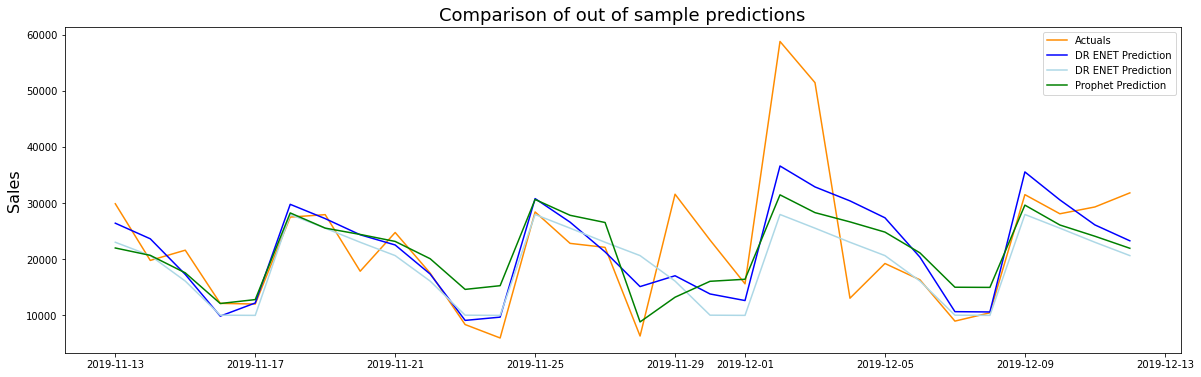

In [410]:
plt.figure(figsize= (20,6))
sns.lineplot(x= 'date', y= 'actual sales', data= training_results, color= 'darkorange', label= 'Actuals')
sns.lineplot(x='date', y= 'DR ENET Prediction', data= training_results, color= 'blue', label= 'DR ENET Prediction')
sns.lineplot(x='date', y= 'DR Eureqa Prediction', data= training_results, color= 'lightblue', label= 'DR ENET Prediction')
sns.lineplot(x= 'date', y= 'Prophet prediction', data= training_results, color= 'green', label= 'Prophet Prediction')
plt.ylabel('Sales', fontsize= 16)
plt.xlabel('')
plt.title('Comparison of out of sample predictions', fontsize= 18)
plt.show();

In [411]:
# calculate RMSE from the two approaches:
print('DataRobot ENET RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['DR ENET Prediction']),2))
print('DataRobot Eureqa RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['DR Eureqa Prediction']),2))
print('Prophet RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['Prophet prediction']),2))

DataRobot ENET RMSE 7869.63
DataRobot Eureqa RMSE 9541.3
Prophet RMSE 8988.64


### The DataRobot Elastic-net model significantly outperforms a simpler Prophet model.

### the Eureqa performance is less accurate here, but this model outputs coefficient, works well with non-linear relationships, and as a results support sub-ms predictions if required

------
# Retrain best models:

### If we want maximum performance from both models, then we should train with all of the data and then make predictions


In [458]:
# now lets retrain both approaches with all of the data
prophet_model2 = Prophet(holidays= prophet_cal, weekly_seasonality= True)
Prophet_max = prophet_model2.fit(df_prophet)
project_1.unlock_holdout()
DR_max = best_model.request_frozen_datetime_model(training_start_date=pd.to_datetime('2017-02-23'), training_end_date=df_agg_single['date'].max())
DR_max = DR_max.get_result_when_complete(max_wait=10000)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


JobAlreadyRequested: 422 client error: {'message': 'This job duplicates a job or jobs that are in the queue or have completed.', 'errorName': 'JobAlreadyAdded', 'previousJob': {'status': 'COMPLETED', 'url': 'https://app.datarobot.com/api/v2/projects/605f727e352a4077ad5e4ab7/modelJobs/62/', 'projectId': '605f727e352a4077ad5e4ab7', 'isBlocked': False, 'id': '62', 'jobType': 'model', 'modelId': '605f7709b4d7a0a3d6b27f9f'}}

In [463]:
# DR best retrained model (I ran this multiple times in testing, and have a duplicate)
DR_max_model = project_1.get_models()[0]

In [468]:
# get training predictions for plotting
prophet_training_preds = Prophet_max.predict(df_prophet)

training_max_request = DR_max_model.request_predictions(training_pred_dataset.id)
DR_max_training_preds = training_max_request.get_result_when_complete()

In [473]:
# we only need the recent actuals for plotting purposes
prophet_recent_training_preds = prophet_training_preds[prophet_training_preds['ds'] >= pd.to_datetime('2019-11-13')]
DR_max_training_preds['timestamp'] = pd.to_datetime(DR_max_training_preds['timestamp']).dt.tz_localize(None)
DR_max_recent_training_preds = DR_max_training_preds[DR_max_training_preds['timestamp'] >= pd.to_datetime('2019-11-13')]

In [428]:
# create scoring dataset through the end of the year
scoring_rows = pd.DataFrame(pd.date_range(start= df_agg_single['date'].max()+pd.DateOffset(1), end= pd.to_datetime('2019-12-31')), columns= ['date'])
scoring_data = df_agg_single.append(scoring_rows)

In [440]:
# get predictions from the models re-trained on all of the training data
Prophet_max_forecast = Prophet_max.predict(scoring_data[['date', 'sales']].rename(columns= {'date': 'ds', 'sales': 'y'}))
scoring_dataset_DR = project_1.upload_dataset(scoring_data, forecast_point= df_agg_single['date'].max())
DR_max_forecast = DR_max.request_predictions(scoring_dataset_DR.id).get_result_when_complete()

In [477]:
DR_max_forecast['timestamp'] = pd.to_datetime(DR_max_forecast['timestamp']).dt.tz_localize(None)

# append these to the training-preds for plotting
Prophet_joint_forecast = pd.concat((prophet_recent_training_preds, Prophet_max_forecast[Prophet_max_forecast['ds']>= pd.to_datetime('2019-11-13')]), axis=0)
DR_joint_forecast = pd.concat((DR_max_recent_training_preds, DR_max_forecast), axis= 0)

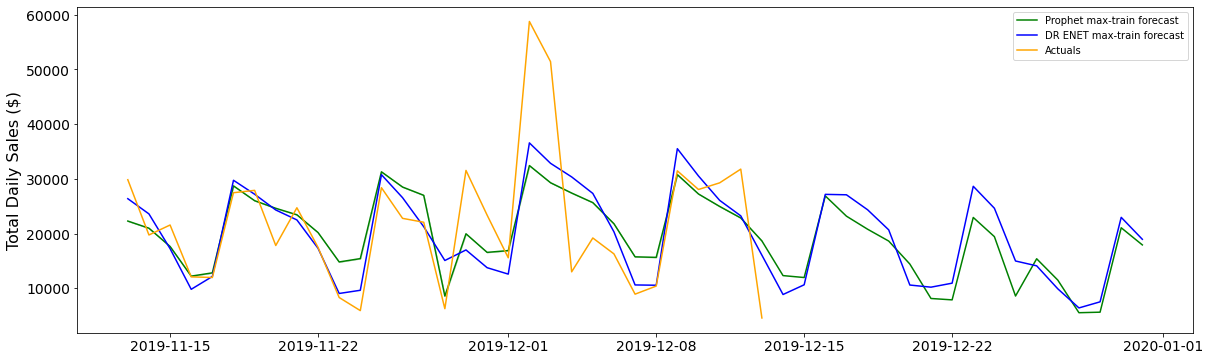

In [682]:
# plot the forecasts and histrical actuals
recent_actuals = df_agg_single[df_agg_single['date']>= pd.to_datetime('2019-11-13')]
plt.figure(figsize= (20,6))
sns.lineplot(x= 'ds', y= 'yhat', data= Prophet_joint_forecast, color= 'green', label= 'Prophet max-train forecast')
sns.lineplot(x= 'timestamp', y= 'prediction', data= DR_joint_forecast, color= 'blue', label= 'DR ENET max-train forecast')
sns.lineplot(x= 'date', y= 'sales', data= recent_actuals, color= 'orange', label= 'Actuals')
plt.ylabel('Total Daily Sales ($)', fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show();

------------
# Build Forecasts, Approach 3: DataRobot multi-series project

### In most cases, we find that multi-series forecasting is more relevant for the business use case. In this case, rather than aggregating sales to the daily level and building models to forecast that single series, we can instead build models that are able to forecast each series independently.

### To facilitate the use of DataRobot Time Series modeling on very large use cases, I will highlight using the python-package (datarobot_s_helpers) that I published and co-authored to make it easy to do really sophisticated forecasting (i.e. 10K+ SKU use cases like this, clustering, etc.), like we do with most of our Fortune 500 clients. Approach 4 will demonstrate what that type of problem framing looks like.

In [442]:
# we'll use this dataset, which is much reacher with features
df_agg_multi['date'] = pd.to_datetime(df_agg_multi['date'])
df_agg_multi.head()

,date,product_id,sales,units_sold,COGs,revenue,mean_tranaction_sales,mean_discount,mean_selling_price,mean_units_sold,mean_COGs,description,color,size,model_number
0,2016-12-13,383372.0,132.00,33.0,54.12,77.88,44.000000,0.046667,4.00,11.000000,18.040000,Cotton T-shirt,WHITE,S,T5000
1,2016-12-14,383379.0,102.70,26.0,39.52,63.18,34.233333,0.040000,3.95,8.666667,13.173333,Cotton T-shirt,WHITE,M,T5000
2,2016-12-15,383386.0,243.10,65.0,100.75,142.35,243.100000,0.060000,3.74,65.000000,100.750000,Cotton T-shirt,WHITE,L,T5000
3,2016-12-16,383393.0,413.92,104.0,167.44,246.48,68.986667,0.033333,3.98,17.333333,27.906667,Cotton T-shirt,WHITE,XL,T5000
4,2016-12-17,384212.0,397.12,73.0,138.70,258.42,66.186667,0.023333,5.44,12.166667,23.116667,Cotton T-shirt,BLACK,S,T5000


In [609]:
# The first thing is to create a project_settings dictionary
target= 'sales'
date_col = 'date'
series_id = 'product_id'
kia = None # sometimes variables are known in advance, like marketing or discounts
dnd= None # features can be excluded from DataRobot's automated feature engineering
num_backtests = 1 # same structure as before
validation_duration = 30 # want to predict 1-month sales, validating on the same period
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' 
use_time_series = True
use_cross_series_features = False
fd_start = 1
fd_end = 30 # forecasting sales for the next month
fdw_start = -30 
fdw_end = 0
max_date = df_agg_multi['date'].max() # for this project, we will exclude the last 30 days
mode= dr.AUTOPILOT_MODE.QUICK # set the modeling mode
n_workers= 25 # you can limit the workers used per project (int) or use all (-1). I typically use 5-20 workers/project, but not all
calendar= cal.id

# create Time Series settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'do_not_derive': dnd,
                'use_cross_series_features': use_cross_series_features,
               'num_backtests':num_backtests, 'validation_duration':validation_duration, 
               'holdout_duration':holdout_duration,'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end,
               'n_workers': n_workers, 'mode': mode, 'calendar': calendar}

### From EDA, I know that many series are irregular (i.e. having missing date records, likely corresponding to zero-sales days for those items). If those rows are missing, then seasonality handling will be problematic.

### Lets run a data quality check

In [491]:
# Data quality check
ts_describe = ts.DataQualityCheck(df_agg_multi, ts_settings)

Running all data quality checks...

There are 49291 rows and 15 columns
There are 70 series
The data spans from  2016-12-13 00:00:00 to 2019-12-13 00:00:00
Data fails hierarchical check! No hierarchical blueprints will run.
Minimum target value is <> 0. Zero-inflated blueprints will not run.
 6.00% of the series appeared after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
100.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Series are irregularly spaced. Projects will only be able to run in row-based mode!
Detected periodicity: ['weekly', 'monthly', 'yearly']


### We should fix that irregularity by filling the missing dates:

In [492]:
# here is a function I've previous written to do this. Overkill for this usecase
def find_fill_missing_dates(df, aggregator, date_col, fill_cols, copy_val_cols= None, start= None, end= None, fill_value= np.nan, fill_val_dict= None, donor_cols= None, date_freq= 'D'):
    '''
    Identifies missing dates, fills missing dates with NaN
    ----
    inputs 
    df: Pandas DataFrame, 
    aggregator: aggregation column (string)
    date_col: primary date-time column (string)
    fill_cols: columns to include (list)
    start (optional): start-date for zero-filling (date-time object)
    end (optional): end-date for zero-filling (date-time object)
    fill_value: default value to place in missing rows + cols (string, numeric, bool)
    fill_val_dict: dictionary of column:fill_value for missing rows (dictionary)
    date_freq: (optional) (str) 
    ----
    outputs: Pandas DataFrame
    '''
    new_df = pd.DataFrame()
    for item in tqdm(df[aggregator].unique().tolist()):
        data = df[df[aggregator] == item]
        s = data[date_col].min()
        e = data[date_col].max()
        if start is not None:
            s = start
        if end is not None:
            e = end
        missing_dates = pd.DataFrame(pd.date_range(start = s, end = e, freq= date_freq).difference(data[date_col]), columns = [date_col])
        missing_dates[aggregator] = item
        for col in fill_cols:
            if fill_val_dict is not None:
                missing_dates[col] = fill_val_dict[col]
            elif col in donor_cols:
                try:
                    missing_dates[col] = data[col].value_counts().idxmax()
                except: 
                    missing_dates[col] = fill_value
            else:
                missing_dates[col] = fill_value
        data = data.append(missing_dates)
        new_df = new_df.append(data)
    return new_df.sort_values(date_col)

In [493]:
# some information is known aprior
known_cols = ['description', 'color', 'size', 'model_number']

# rows with other missing values would need to be filled if this modeling was run outside of DataRobot. 
# But DataRobot will automatically deal with missing values

In [494]:
df_agg_multi_filled = find_fill_missing_dates(df= df_agg_multi,
                                             aggregator= 'product_id',
                                             date_col= 'date',
                                             fill_cols = ['sales'] + known_cols,
                                             fill_value= 0,
                                             donor_cols= known_cols)
# def find_fill_missing_dates(df, aggregator, date_col, fill_cols, copy_val_cols= None, start= None, end= None, fill_value= np.nan, fill_val_dict= None, donor_cols= None, date_freq= 'D'):


100%|██████████| 70/70 [00:01<00:00, 61.09it/s]


In [498]:
# how many rows were added?
print('Original dataset row count: ', df_agg_multi.shape[0])
print('Filled dataset row count: ', df_agg_multi_filled.shape[0])
print(f'Dataset grew { np.round(100*(df_agg_multi_filled.shape[0]-df_agg_multi.shape[0])/df_agg_multi.shape[0],2)}%')

Original dataset row count:  49291
Filled dataset row count:  76266
Dataset grew 54.73%


In [501]:
# save the new dataset
df_agg_multi_filled.to_csv('data/multi_series_filled.csv', index= None)

# we can also train a univariate, multiseries dataset to see how useful the covariates are
df_agg_multi_filled_univariate = df_agg_multi_filled[['date', 'product_id', 'sales']]
df_agg_multi_filled_univariate.to_csv('data/multi_series_univariate_filled.csv', index= None)

In [499]:
# Data quality check
ts_describe = ts.DataQualityCheck(df_agg_multi_filled, ts_settings)

Running all data quality checks...

There are 76266 rows and 15 columns
There are 70 series
The data spans from  2016-12-13 00:00:00 to 2019-12-13 00:00:00
Data passes hierarchical check! DataRobot hierarchical blueprints will run if you enable cross series features.
The minimum target value is zero. Zero-Inflated blueprints will run.
 6.00% of the series appeared after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
0.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Timesteps are regularly spaced. You will be able to run projects in either time-based or row-based mode
Detected periodicity: ['weekly', 'monthly', 'yearly']


# Run train the simple model below:

In [610]:
# we only need to build a forecast for the next 18 days, but instead let's just do a 30-day forecast for simplicity

# build separate projects by FD, FDW, and/or cluster
fdws = [(-35,0)] # Automated Feature engineering will occur with different windows, just using one here
fds = [(1,30)] # in this case, predicting one month is the goal

project_2 = ts.create_dr_projects(df_agg_multi_filled_univariate, 
                             ts_settings, 
                             prefix='JS:simple_univariate_multiseries_approach', # provide a prefix that will make it easy to search for only these projects
                             split_col= None, 
                             fdws=fdws, 
                             fds=fds) 

Building 1 projects: 100%|██████████| 1/1 [05:56<00:00, 356.79s/it, Project JS:simple_univariate_multiseries_approach_FD:1-30_FDW:-35_all_series was successfully built!]

***** All 1 projects were successfully built! *****



In [611]:
# we only need to build a forecast for the next 18 days, but instead let's just do a 30-day forecast for simplicity

# build separate projects by FD, FDW, and/or cluster
fdws = [(-35,0)] # Automated Feature engineering will occur with different windows, just using one here
fds = [(1,30)] # in this case, predicting one month is the goal

project_3 = ts.create_dr_projects(df_agg_multi_filled, 
                             ts_settings, 
                             prefix='JS:simple_multiseries_approach', # provide a prefix that will make it easy to search for only these projects
                             split_col= None, 
                             fdws=fdws, 
                             fds=fds) 

Building 1 projects: 100%|██████████| 1/1 [06:32<00:00, 392.50s/it, Project JS:simple_multiseries_approach_FD:1-30_FDW:-35_all_series was successfully built!]

***** All 1 projects were successfully built! *****



-----
# Build Forecasts, Approach 4: Complex multi-series modeling with DataRobot

### I will demonstrate building a complex forecasting setup like we do with many Fortune 500 clients, using more of the functionality in the packge I co-created. This approach is likely overkill for a 'smaller' problem with this dataset (70 series).

### This larger, scale 'segmented' approach is what we've found typically works best when there are a large number of series with distinct sales patterns. This approach is just illustrated here, but we have scaled to 100k+ SKU (100M total series with sales from different brick-and-mortar stores). At that scale, things take longer to computer than for this small dataset.

In [621]:
# we want to avoid using the holdout data for clustering as it can be subtle target leakage
training_multi = df_agg_multi_filled[df_agg_multi_filled['date'] < df_agg_multi_filled['date'].max()+pd.DateOffset(-30)]

## Clustering Series

#### There are many different ways to cluster data, and often it can be difficult to find the 'right' number of clusters. Typically plotting in a few ways will yield reasonable information for a 'sniff test'

Testing 2 to 14 clusters
For n_clusters = 2, silhouette score is 0.526650624290421
For n_clusters = 3, silhouette score is 0.540620673386275
For n_clusters = 4, silhouette score is 0.4589678001605316
For n_clusters = 5, silhouette score is 0.38944427506066925
For n_clusters = 6, silhouette score is 0.2762381435483538
For n_clusters = 7, silhouette score is 0.30827696016387274
For n_clusters = 8, silhouette score is 0.3130099881971306
For n_clusters = 9, silhouette score is 0.3387813092190052
For n_clusters = 10, silhouette score is 0.3369690589169898
For n_clusters = 11, silhouette score is 0.3672355561322034
For n_clusters = 12, silhouette score is 0.385466765537436
For n_clusters = 13, silhouette score is 0.37270166816121497
For n_clusters = 14, silhouette score is 0.37450549090035556
optimal n_clusters = 3, max silhouette score is 0.540620673386275


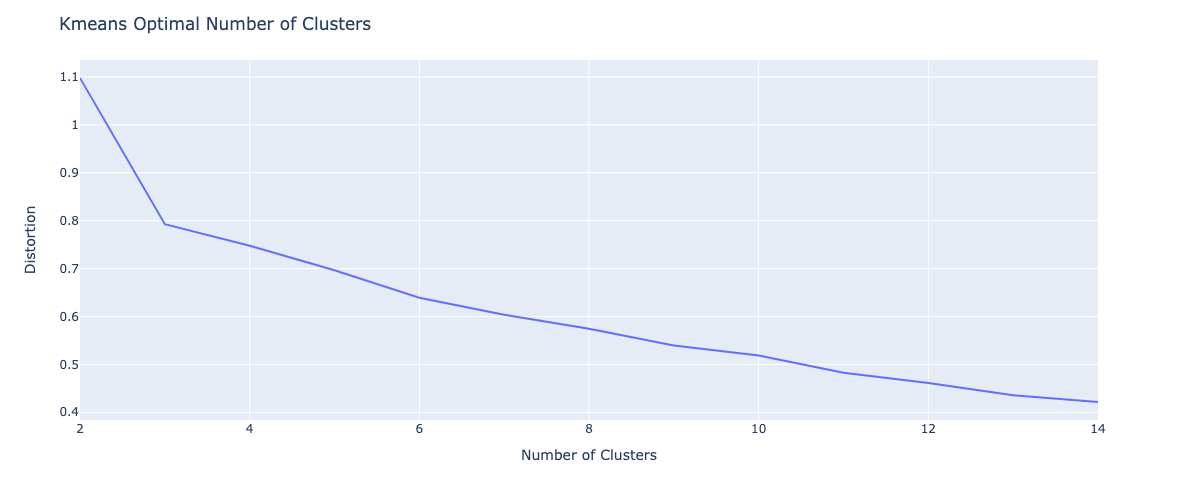

In [622]:
# Series clustering using 'correlation'
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=None # providing a value for n_clusters will force that number of clusters to be used
max_clusters=14 # this needs to be < # series
plot=True

df_w_clusters =  ts.add_cluster_labels(training_multi, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=plot)

### There is a very nice bend at 3-clusters in this elbow plot. Lets plot these clustering results

/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




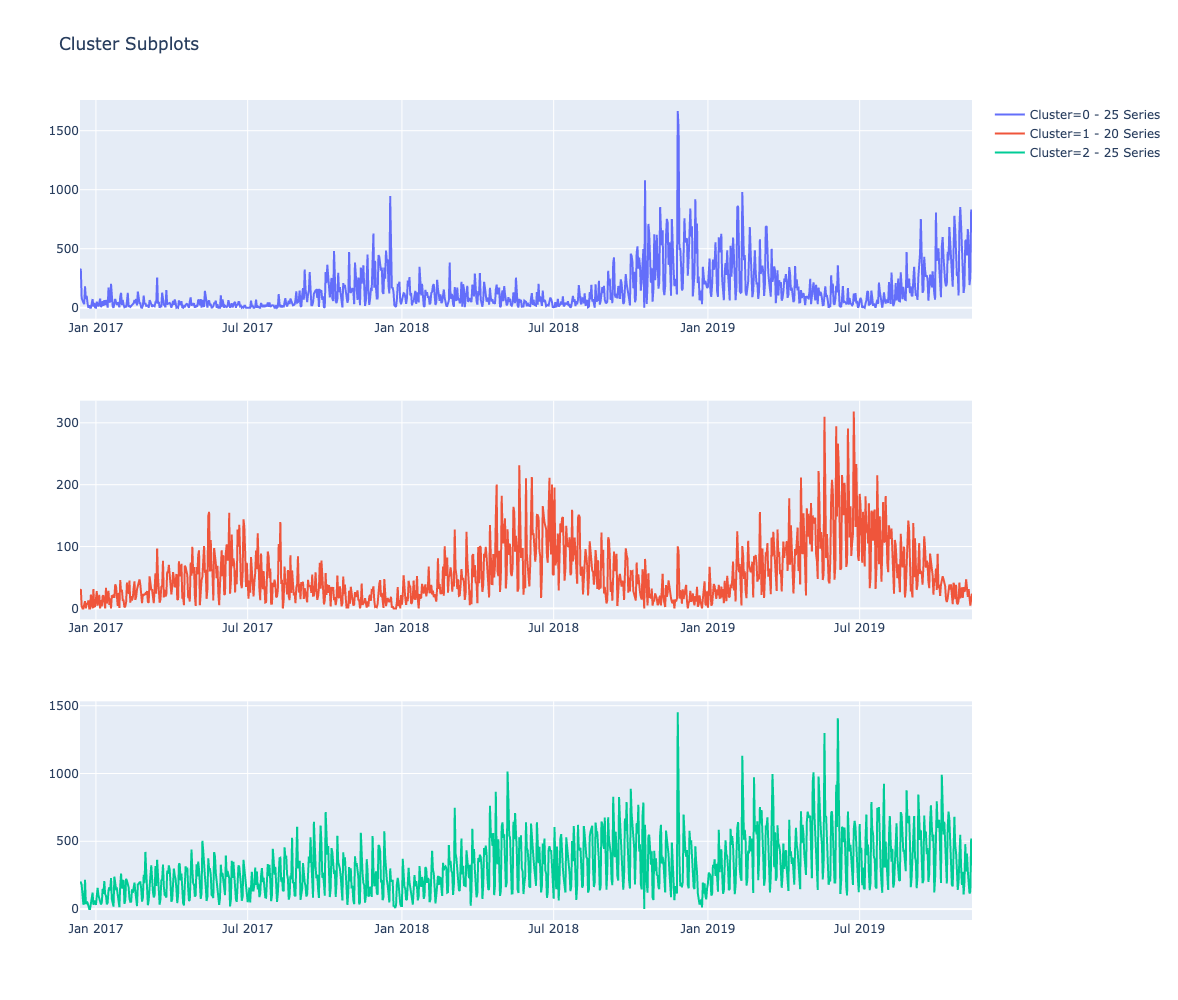

In [624]:
ts.plot_clusters(df_w_clusters, ts_settings)

### This clustering seems to detect two different annual-seasonal patterns and third cluster with more constant selling items with smaller-scale seasonality. Looks good.

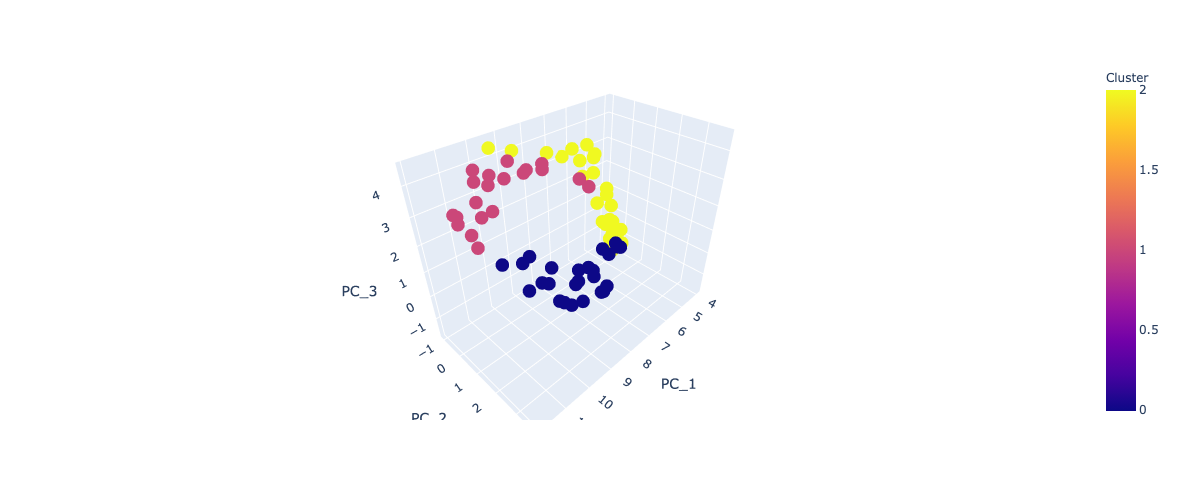

In [625]:
# reshape the dataframe for dimensionality reduction
clusters_t_scaled = ts.reshape_df(df_w_clusters, ts_settings, scale= True)

# perform dimensionality reduction and plot the clustered data with labels
ts.plot_UMAP(clusters_t_scaled, df_w_clusters, ts_settings)

### We see really nice separation of these clusters (for the most part) and the hint of the typical "corkscrew" or "ram's horn" shape that retail data often has in a dimensionally reduced 3-d plot.

### We will proceed with this cluster assignment

In [626]:
# add the cluster labels onto the full dataset
cluster_dict = dict(zip(df_w_clusters.groupby('product_id').mean().index, df_w_clusters.groupby('product_id').mean()['Cluster'].values))
df_agg_multi_filled['Cluster'] = df_agg_multi_filled['product_id'].map(cluster_dict)

In [627]:
# create cross series features
# these features will be generated at the cluster-level
df_w_clusters = ts.create_cross_series_features(df_agg_multi_filled, 
                                             group=['date','Cluster'], 
                                             cols=['sales', 'units_sold'], 
                                             funcs=['mean','median','std','min','max'])
df_w_clusters.head(2)

,date,product_id,sales,units_sold,COGs,revenue,mean_tranaction_sales,mean_discount,mean_selling_price,mean_units_sold,mean_COGs,description,color,size,model_number,sales_mean,sales_median,sales_std,sales_min,sales_max,units_sold_mean,units_sold_median,units_sold_std,units_sold_min,units_sold_max,Cluster
0,2016-12-13,383372.0,132.0,33.0,54.12,77.88,44.000000,0.046667,4.00,11.000000,18.040000,Cotton T-shirt,WHITE,S,T5000,228.055833,152.495,219.69898,15.69,809.07,41.041667,28.5,37.736477,3.0,149.0,2
1,2016-12-13,383379.0,102.7,26.0,39.52,63.18,34.233333,0.040000,3.95,8.666667,13.173333,Cotton T-shirt,WHITE,M,T5000,228.055833,152.495,219.69898,15.69,809.07,41.041667,28.5,37.736477,3.0,149.0,2


In [628]:
# save this dataset
df_w_clusters.to_csv('data/multi_series_filled_clustered.csv', index= None)

## Now we can build separate DataRobot projects for each cluster. And optimize project config and performance for each segment of the data

In [629]:
# we only need to build a forecast for the next 18 days, but instead let's just do a 30-day forecast for simplicity

# build separate projects by FD, FDW, and/or cluster
fdws = [(-56,0), (-35,0), (-14,0), (-7,0)] # Automated Feature engineering will occur with different windows, just using one here
fds = [(1,30)] # in this case, predicting one month is the goal

project_4 = ts.create_dr_projects(df_w_clusters, 
                             ts_settings, 
                             prefix='JS:complex_multiseries_approach', # provide a prefix that will make it easy to search for only these projects
                             split_col= 'Cluster', 
                             fdws=fdws, 
                             fds=fds) 

Building 12 projects: 100%|██████████| 12/12 [10:19:09<00:00, 3095.81s/it, Project JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-1 was successfully built!]  

***** All 12 projects were successfully built! *****



### Looks like there were some connection issues when these 12 project, but things resolved successfully with retries.

In [631]:
# compute performance fot top-5 models from each project
ts.compute_backtests(project_2, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(project_3, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')
ts.compute_backtests(project_4, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')


All available backtests have been submitted for scoring for project JS:simple_univariate_multiseries_approach_FD:1-30_FDW:-35_all_series
All available backtests have been submitted for scoring for project JS:simple_multiseries_approach_FD:1-30_FDW:-35_all_series
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_FDW:-56_Cluster-2
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_FDW:-35_Cluster-2
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_FDW:-14_Cluster-2
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-2
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_FDW:-56_Cluster-0
All available backtests have been submitted for scoring for project JS:complex_multiseries_approach_FD:1-30_

In [632]:
%%time
# Get the results from completed projects
project2_scores = ts.get_or_request_backtest_scores(project_2, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

project3_scores = ts.get_or_request_backtest_scores(project_3, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

project4_scores = ts.get_or_request_backtest_scores(project_4, 
                                               n_models=5, 
                                               data_subset='allBacktests', 
                                               include_blenders=False, 
                                               metric='RMSE')

Scores for all 1 projects have been computed
Scores for all 1 projects have been computed
Scores for all 12 projects have been computed
CPU times: user 707 ms, sys: 11.7 ms, total: 719 ms
Wall time: 33.4 s


In [633]:
# because we ran projects with different configs, we will select the best option for each cluster
scores2_best = ts.filter_best_fdw_scores(project2_scores, col_error='All_Backtests_RMSE')
scores3_best = ts.filter_best_fdw_scores(project3_scores, col_error='All_Backtests_RMSE')
scores4_best = ts.filter_best_fdw_scores(project4_scores, col_error='All_Backtests_RMSE')
project4_best = ts.filter_best_fdw_projects(project4_scores, project_4, col_error='All_Backtests_RMSE')
project4_best

[Project(JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-2),
 Project(JS:complex_multiseries_approach_FD:1-30_FDW:-56_Cluster-0),
 Project(JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-1)]

### We see that different Feature Derivation windows were selected for some of the clusters. Clusters 1 & 2 (Annual-seasonality-B and constant selling items) were optimially modeled with a short window (past 7 days), while Cluster 0 (annual-seasonality-A) utilized a very long window (last 8 weeks).

### Interestingly, a different modeling approach (Ridge Regressor based) was selected with this long feature derivation window while both approaches with a short window used an XGBoost-based approach (although with different feature processing - differencing).

In [634]:
scores4_best.head()

,Project_Name,Project_ID,Model_ID,Model_Type,Featurelist,Backtest_1_RMSE,Backtest_1_MASE,Backtest_1_Theils_U,Backtest_1_SMAPE,Backtest_1_R_Squared,All_Backtests_RMSE,All_Backtests_MASE,All_Backtests_Theils_U,All_Backtests_SMAPE,All_Backtests_R_Squared,Holdout_RMSE,Holdout_MASE,Holdout_Theils_U,Holdout_SMAPE,Holdout_R_Squared
20,JS:complex_multiseries_approach_FD:1-30_FDW:-5...,60600575ab2d92f5784ea1f1,606009e2ef40e2c39ee00c9f,Ridge Regressor with Forecast Distance Modelin...,DR Reduced Features M21,327.30460,0.79833,0.75244,79.50865,0.73126,[327.3046],[0.79833],[0.75244],[79.50865],[0.73126],None,None,None,None,None
55,JS:complex_multiseries_approach_FD:1-30_FDW:-7...,606083e36d5b8d01504e9f10,60608e3d4842e4b057dccd82,eXtreme Gradient Boosting Regressor with Early...,No Differencing,37.09658,0.76549,0.61661,136.71869,0.37305,[37.09658],[0.76549],[0.61661],[136.71869],[0.37305],None,None,None,None,None
15,JS:complex_multiseries_approach_FD:1-30_FDW:-7...,6060041cab2d92f5784ea1eb,6060080e7548cf7c4be00c8c,eXtreme Gradient Boosting Regressor with Early...,DR Reduced Features M24,210.36102,0.79414,0.71376,57.90117,0.69203,[210.36102],[0.79414],[0.71376],[57.90117],[0.69203],None,None,None,None,None


## Let's compare the accuracy of the various approaches

In [635]:
print('Project_2: Multi-series univariate models RMSE: ', scores2_best['Backtest_1_RMSE'].values[0])
print('Project_3: Multi-series multi-variate models RMSE: ', scores3_best['Backtest_1_RMSE'].values[0])
print('Project_4: Complex multi-series models RMSE: ', scores4_best['Backtest_1_RMSE'].mean())


Project_2: Multi-series univariate models RMSE:  261.5761
Project_3: Multi-series multi-variate models RMSE:  258.27982
Project_4: Complex multi-series models RMSE:  191.5874


### Not surprisingly, the most complex approach yields the highest accuracy. In all cases, there is the performance vs. complexity tradeoff that needs to be assessed. The value and necessity of complex approaches is dependent both on the dataset and the value or marginal performance improvement (although the ~ 25% performance improvement here is not marginal)

Getting cluster accuracy...


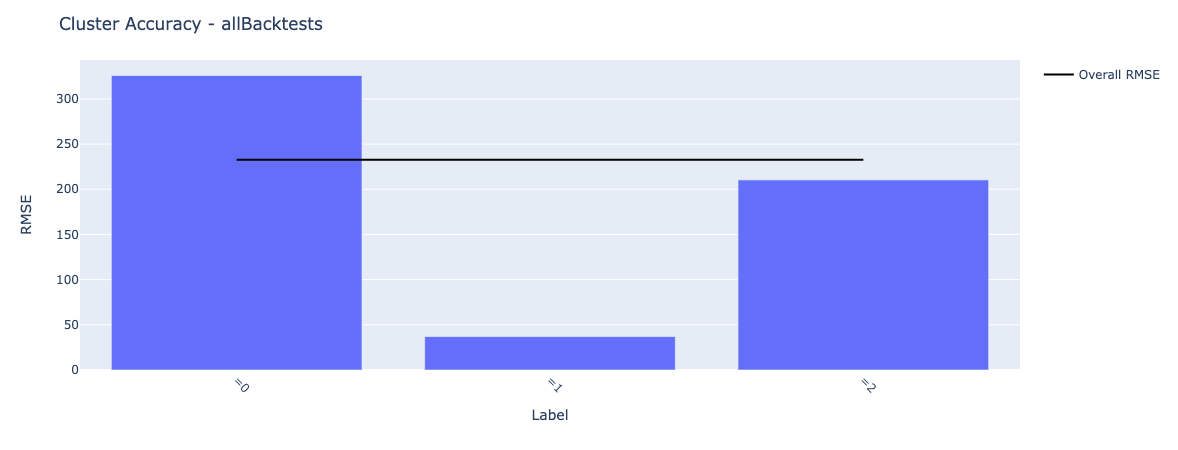

CPU times: user 12.4 s, sys: 427 ms, total: 12.8 s
Wall time: 2min 25s


In [636]:
%%time
# you can easily see the performance across clusters and series
cluster_acc = ts.get_cluster_acc(df_w_clusters, 
                                 project4_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=True, 
                                 metric='RMSE', 
                                 acc_calc=ts.rmse)
ts.plot_cluster_acc(cluster_acc, ts_settings, data_subset='allBacktests', acc_calc=ts.rmse)

Getting cluster accuracy...


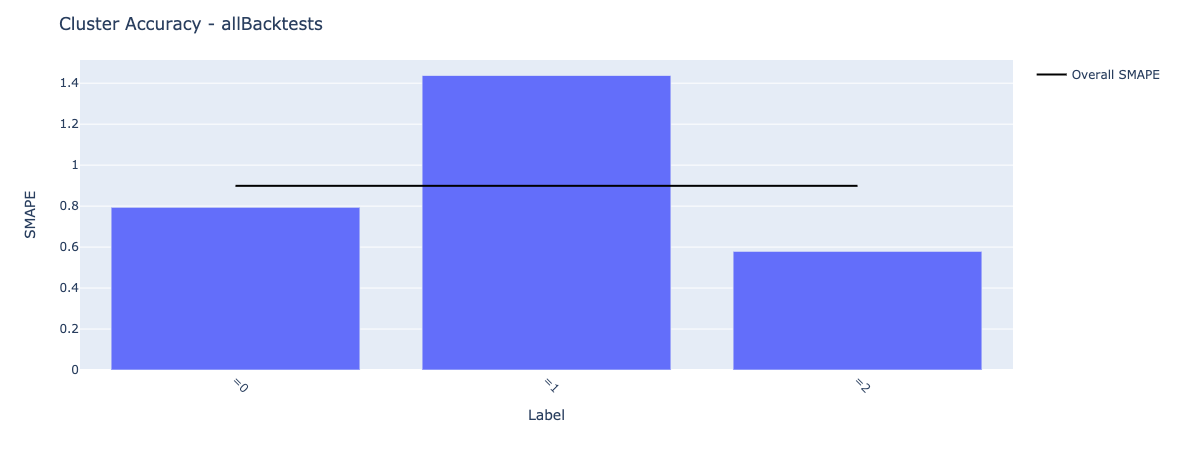

CPU times: user 12.4 s, sys: 418 ms, total: 12.8 s
Wall time: 35.1 s


In [637]:
%%time
# RMSE can be decieving when we've clustered and mean target value may vary
# re-run with a different metric (SMAPE) that is agnostic to target-value
cluster_acc_smape = ts.get_cluster_acc(df_w_clusters, 
                                 project4_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=True, 
                                 metric='SMAPE', 
                                 acc_calc=ts.smape)
ts.plot_cluster_acc(cluster_acc_smape, ts_settings, data_subset='allBacktests', acc_calc=ts.smape)

### Interestingly, RMSE and SMAPE tell the opposite story regarding performance.

### Regardless, we've build models here with < 1% Symmetrical Mean Absolute Percentage Error  (SMAPE), a series-scale agnostic value.

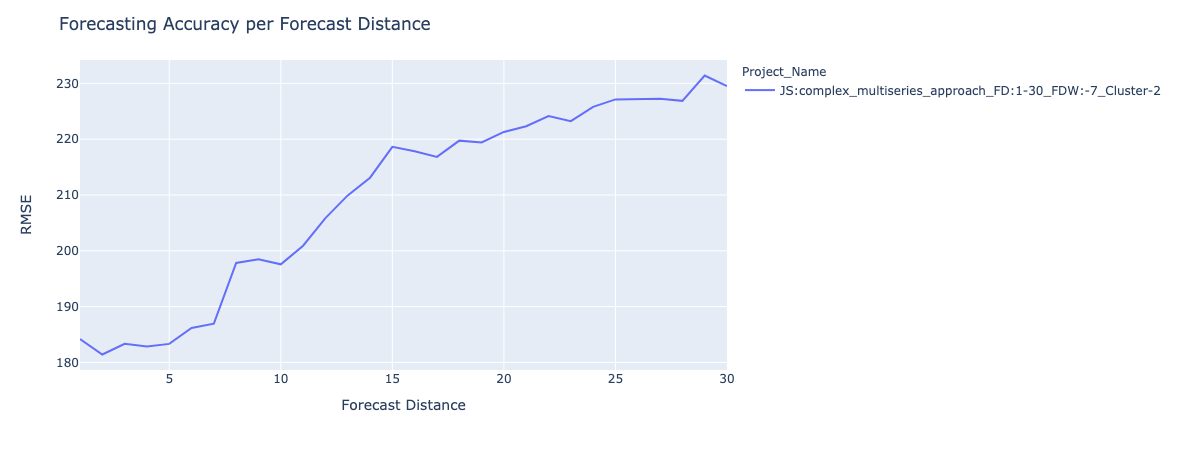

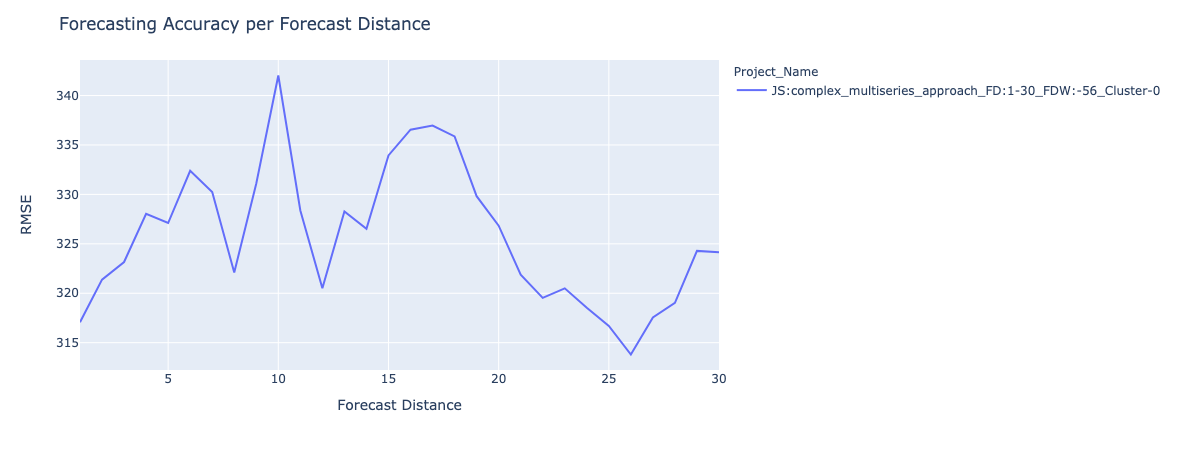

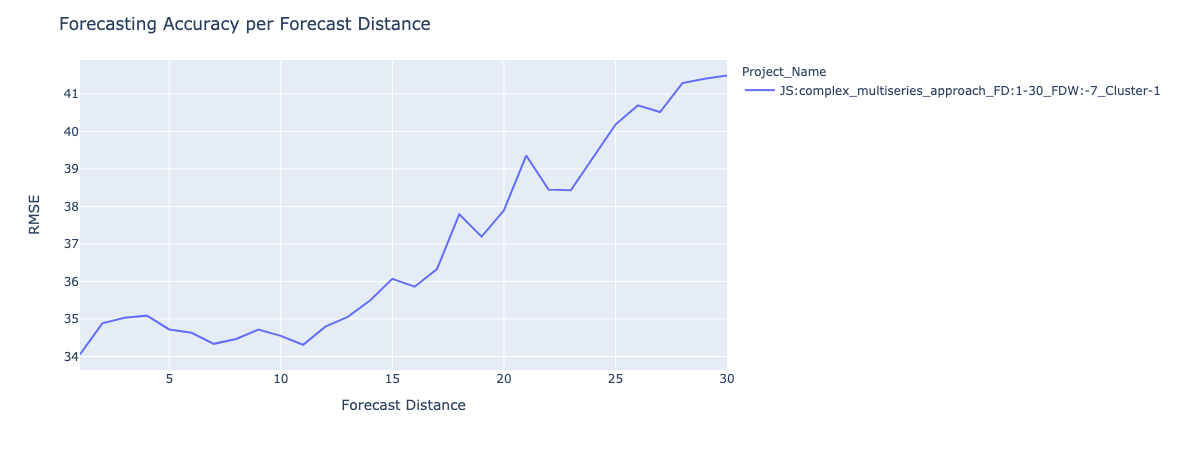

In [639]:
# this allows you to see how accuracy varies depending on how far into the future you are forecasting
# this is one of the main advantages of a forecast-distance modeling approach, as opposed to a rolling or recursive approach
ts.plot_fd_accuracy_by_cluster(df_w_clusters, project4_scores, project4_best, ts_settings, data_subset='allBacktests', metric='RMSE')

### We can see that the Clusters that used a short feature derivation window (7 days) have declining performance across the forecast horizon (1-30 days) as opposed to the cluster-0 that used a long feature derivation window (8 weeks). If we really wanted to maximize performance, there are additional approaches to pursue here.

In [663]:
# lets unlock the holdout to get the predictions on the training, validation, and holdout data
[x.unlock_holdout() for x in project4_best]

[Project(JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-2),
 Project(JS:complex_multiseries_approach_FD:1-30_FDW:-56_Cluster-0),
 Project(JS:complex_multiseries_approach_FD:1-30_FDW:-7_Cluster-1)]

In [676]:
%%time
# get predictions for all series
# this function can take a while to run
train_predictions = ts.get_preds_and_actuals(df= df_w_clusters, projects= project4_best, ts_settings= ts_settings, include_blenders= True, metric= 'RMSE', data_subset= 'allBacktests')
test_predictions = ts.get_preds_and_actuals(df= df_w_clusters, projects= project4_best, ts_settings= ts_settings, include_blenders= True, metric= 'RMSE', data_subset= 'holdout')
joint_predictions = pd.concat((train_predictions, test_predictions), axis= 0)

CPU times: user 23.2 s, sys: 614 ms, total: 23.8 s
Wall time: 1min 9s


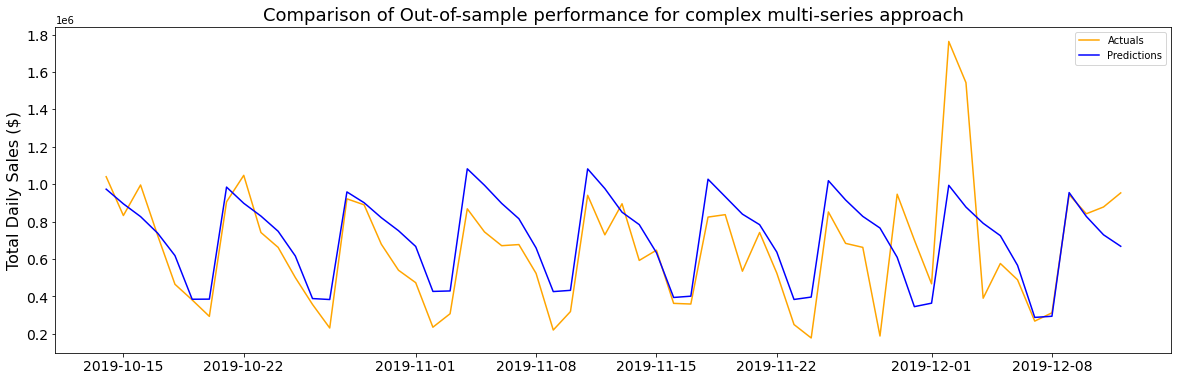

In [686]:
# We can plot the accuracy for the sum of all series predictions
plt.figure(figsize= (20,6))
sns.lineplot(x= 'date', y= 'sales', data= joint_predictions.groupby('date').sum().reset_index(), color= 'orange', label= 'Actuals')
sns.lineplot(x= 'date', y= 'prediction', data= joint_predictions.groupby('date').sum().reset_index(), color= 'blue', label= 'Predictions')
plt.ylabel('Total Daily Sales ($)', fontsize= 16)
plt.xlabel('')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Comparison of Out-of-sample performance for complex multi-series approach', fontsize= 18)
plt.show();

In [685]:
# calculate RMSE from all of these approaches:
print('DataRobot ENET RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['DR ENET Prediction']),2))
print('DataRobot Eureqa RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['DR Eureqa Prediction']),2))
print('Prophet RMSE', np.round(ts.rmse(training_results['actual sales'], training_results['Prophet prediction']),2))
print('DataRobot multi-series complex RMSE', np.round(ts.rmse(joint_predictions.groupby('date').sum().reset_index()['sales'], joint_predictions.groupby('date').sum().reset_index()['prediction']),2))

DataRobot ENET RMSE 7869.63
DataRobot Eureqa RMSE 9541.3
Prophet RMSE 8988.64
DataRobot multi-series complex RMSE 220762.49


### Not surprisingly, the multi-series complex approach is less accurate if we compare performance on a daily aggregate level. This is entirely expected as we saw some data quality issues with the multi-series data (~50% of rows were missing) and we are trying to capture many more trends with the models. So, for this use case forecasting our daily aggregate sales is substantially more accurate.

### In many cases, however, forecasting at the individual series-level is more relevant to the business problem. You will not make product-inventory decisions on aggregate sales or demand forecasts. Rather, we need to forecast the individual units (series => products) at which an actionable decision will be made. If items may be fulfilled from different distribution centers or warehouses, then we may want to consider forecasting at the product-warehouse level to get highly granular demand forecasts that more closely pair with actionable business decisions, even if accurate suffers compared to an aggregate approach.

------
------
# Wrapping up
-----
-----

### There are many more things that can be done with this data regarding improving forecast performance or enhanced insights. Given that we saw distinct seaonal-trends across series, I would be interested in performing post-prediction analysis with the DataRobot prediction explanations. A technique known as 'prediction explanation clustering' would allow for post-prediction insights into differnet drivers of demand, which might correspond to actionable product interventions (i.e. discounts, base-price, etc.). There are also many ways to improve performance of the complex, multi-series approach, but given the time-consideration these won't be pursued here.